In [1]:
import re
import os
import sys
import math
import time
import json
import torch
import random
import unicodedata
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
def update_progress(progress,line):
    '''
    update_progress() : Displays or updates a console progress bar
    Accepts a float between 0 and 1. Any int will be converted to a float.
    A value under 0 represents a 'halt'.
    A value at 1 or bigger represents 100%
    '''
    barLength = 50 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{:s}] {:.2f}% {:s} {:s}".format( "█"*block + "-"*(barLength-block), progress*100, status,line)
    sys.stdout.write(text)
    sys.stdout.flush()

In [11]:
class TrainDataset(Dataset):
    class Voc:        
        def __init__(self,name):
            self.name = name
            self.SOS_token = 0
            self.EOS_token = 1
            self.PAD_token = 2   
            self.tokens = set()
            self.size = len(self.tokens)
        def process(self):
            self.index2word = {**{0: "SOS", 1: "EOS", 2:"PAD"},**dict(enumerate(self.tokens,start=3))}
            self.word2index = dict(map(reversed,enumerate(self.tokens,start=3)))
            self.size = len(self.index2word)
            
    def __init__(self):
        self.input = self.prepare_data(*self.read_data())[:10000]
        self.voc,self.MAX_LENGTH = self.prepare_voc(self.input)
        self.transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        ])
        
    def read_data(self):
        with open('../data/raw/v2_Annotations_Val_mscoco/v2_mscoco_val2014_annotations.json') as fp:
            answers = json.load(fp)['annotations']        
        with open('../data/raw/v2_Questions_Val_mscoco/v2_OpenEnded_mscoco_val2014_questions.json') as fp:
            questions = json.load(fp)['questions']
        return questions,answers

    
    def prepare_data(self,questions,answers):
        question = pd.DataFrame(questions)
        answer = pd.DataFrame(answers)
        return question.merge(answer,how="left",on=['question_id','image_id'])
    
    def prepare_voc(self,data):
        voc = self.Voc('MyVoc')
        data['question'].apply(self.normalize).apply(voc.tokens.update)
        data['multiple_choice_answer'].apply(self.normalize).apply(voc.tokens.update)
#         self.input['answers'].apply(lambda x: [an for y in x for an in self.normalize(y['answer'])]).apply(voc.update)
        voc.process()
        MAX_LENGTH = data[['question','multiple_choice_answer']].apply(lambda x:max(map(len,map(str.split,x))),axis=1).max()
        return voc,MAX_LENGTH
    
    def normalize(self,sentence):
        '''
            filter + lower + split
        '''
        s = re.sub('[.?!]+','',sentence)
        return s.lower().split()
        
    def __len__(self):
        return len(self.input)
    
    def sentence_to_index(self,voc,sentence,max_len):
        indexes = [voc.word2index[word] for word in self.normalize(sentence)]+[voc.EOS_token]
        return np.array(indexes + [voc.PAD_token]*(max_len-len(indexes))),np.array(len(indexes))
        
    def __getitem__(self, idx):
        question = self.input['question'][idx]
        question,ques_len = self.sentence_to_index(self.voc,question,self.MAX_LENGTH)
        answer = self.input['multiple_choice_answer'][idx]
        answer,ans_len = self.sentence_to_index(self.voc,answer,self.MAX_LENGTH)
        image = self.input['image_id'][idx]
        image = Image.open('../data/raw/{typ}/COCO_{typ}_000000{idx:06d}.jpg'.format(typ='val2014',idx=image))
        image = image.convert('RGB')
        image = self.transform(image)
        return image,question,ques_len,answer

In [12]:
train_dataset = TrainDataset()

In [13]:
batch_size = 5
validation_split = 0.4
shuffle_dataset = True
random_seed= 42
# Creating data indices for training and validation splits:
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,sampler=validation_sampler)

In [14]:
class DynamicEncoderRNN(nn.Module):
    def __init__(self, input_size, embed_size,hidden_size, n_layers=1):
        super(DynamicEncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size,n_layers,bidirectional=True)

    def forward(self,input_seqs, input_lens, hidden=None):
        batch_size = input_seqs.size(0)
        input_lens,sort_idx = input_lens.sort(dim=0, descending=True)
        input_seqs = input_seqs[sort_idx]
        input_seqs = input_seqs.transpose(0, 1) # [T,B,E]
        embedded = self.embedding(input_seqs)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lens)
        outputs, hidden = self.gru(packed,hidden)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, :,self.hidden_size:]
        _,unsort_idx= sort_idx.sort(dim=0)
        outputs = outputs.transpose(0, 1)[unsort_idx].transpose(0, 1).contiguous()
        hidden = hidden.transpose(0, 1)[unsort_idx].transpose(0, 1).contiguous()
        return outputs, hidden

    def init_hidden(self,batch_size):
        result = Variable(torch.zeros(2,batch_size, self.hidden_size))
        return result

In [15]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 3, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.normal_(mean=0, std=stdv)

    def forward(self, hidden, encoder_outputs,vision_features):
        '''
        :param hidden: 
            previous hidden state of the decoder, in shape (layers*directions,B,H)
        :param encoder_outputs:
            encoder outputs from Encoder, in shape (T,B,H)
        :return
            attention energies in shape (B,T)
        '''
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)
        H = hidden.repeat(max_len,1,1)
        V = vision_features.view(1,this_batch_size,-1).expand_as(encoder_outputs)
        H = H.transpose(0,1)
        encoder_outputs = encoder_outputs.transpose(0,1) # [B*T*H]
        V = V.transpose(0,1)
        attn_energies = self.score(H,encoder_outputs,V) # compute attention score
        return F.softmax(attn_energies).unsqueeze(1) # normalize with softmax

    def score(self, hidden, encoder_outputs,vision_features):
        all_features = torch.cat([hidden, encoder_outputs,vision_features], 2)
        # TODO use conv instead of Linear to rescue from overfitting
        energy = F.tanh(self.attn(all_features)) # [B*T*3H]->[B*T*H]
        energy = energy.transpose(2,1) # [B*H*T]
        v = self.v.repeat(encoder_outputs.data.shape[0],1).unsqueeze(1) #[B*1*H]
        energy = torch.bmm(v,energy) # [B*1*T]
        return energy.squeeze(1) #[B*T]

In [ ]:
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, embed_size, output_size, n_layers=2, dropout_p=0.5):
        super(BahdanauAttnDecoderRNN, self).__init__()
        # Define parameters
        self.hidden_size = hidden_size
        self.embed_size = embed_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        # Define layers
        self.embedding = nn.Embedding(output_size, embed_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = Attn('concat', hidden_size)
        self.gru = nn.GRU(hidden_size + embed_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout_p))
        self.attn_combine = nn.Linear(hidden_size + embed_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, word_input, last_hidden, encoder_outputs,vision_features):
        '''
        :param word_input:
            word input for current time step, in shape (B)
        :param last_hidden:
            last hidden stat of the decoder, in shape (layers*direction*B*H)
        :param encoder_outputs:
            encoder outputs in shape (T*B*H)
        :return
            decoder output
        Note: we run this one step at a time i.e. you should use a outer loop 
            to process the whole sequence
        Tip(update):
        EncoderRNN may be bidirectional or have multiple layers, so the shape of hidden states can be 
        different from that of DecoderRNN
        You may have to manually guarantee that they have the same dimension outside this function,
        e.g, select the encoder hidden state of the foward/backward pass.
        '''
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, word_input.size(0), -1) # (1,B,V)
        word_embedded = self.dropout(word_embedded)
        # Calculate attention weights and apply to encoder outputs
        attn_weights = self.attn(last_hidden[-1], encoder_outputs,vision_features)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))  # (B,1,V)
        context = context.transpose(0, 1)  # (1,B,V)
        # Combine embedded input word and attended context, run through RNN
        rnn_input = torch.cat((word_embedded, context), 2)
        # rnn_input = self.attn_combine(rnn_input) # use it in case your size of rnn_input is different
        output, hidden = self.gru(rnn_input, last_hidden)
        output = output.squeeze(0)  # (1,B,V)->(B,V)
        # context = context.squeeze(0)
        # update: "context" input before final layer can be problematic.
        # output = F.log_softmax(self.out(torch.cat((output, context), 1)))
        output = F.log_softmax(self.out(nn.Dropout(0.3)(output)))
        # Return final output, hidden state
        return output, hidden

In [ ]:
class EncoderResnet(nn.Module):
    def __init__(self,output_channel):
        super(EncoderResnet, self).__init__()
        resnet152 = models.resnet152(pretrained=True)
        modules=list(resnet152.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.out = nn.Conv2d(2048,output_channel,1,bias=True)
        
    def forward(self,img):
        output = self.resnet(img)
        output = self.out(output)
        return output

In [ ]:
class VQAModel(nn.Module):
    def __init__(self,input_voc_size,output_voc_size,embd_size,hidden_size):
        super(VQAModel, self).__init__()
        self.text_encoder = DynamicEncoderRNN(input_voc_size,embd_size,hidden_size)
        self.image_encoder = EncoderResnet(hidden_size)
        self.decoder = BahdanauAttnDecoderRNN(hidden_size,embd_size,output_voc_size)

    def forward(self,img,question,ques_len,answers):
        # encode
        encoder_outpus,last_hidden = self.text_encoder(question,ques_len)
        vision_features = self.image_encoder(img)
        # decode
        batch_size = ques_len.size(0)
        word_input = torch.Tensor([0]*batch_size).long()
        output = torch.FloatTensor()
        if torch.cuda.is_available():
            word_input = word_input.cuda()
            output = output.cuda()
#         for seq in answers.transpose(0,1):
        for _ in range(train_dataset.MAX_LENGTH):
            word_output,last_hidden = self.decoder(word_input,last_hidden,encoder_outpus,vision_features)
            topv, topi = word_output.topk(1)
            word_input = topi.squeeze(1)
#             word_input = seq
            word_output = word_output.view(batch_size,-1,1)
            output = torch.cat((output,word_output),dim=2)
        return output

In [ ]:
model = VQAModel(train_dataset.voc.size,train_dataset.voc.size,64,512)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [12]:
model = torch.load('../models/MyModel.pt')

In [ ]:
def train():
    completed = 0
    total_loss = torch.zeros(1).cuda()
    total_accuracy = torch.zeros(1).cuda()
    model.train()
    for batch_idx,(image,question,ques_len,answer) in enumerate(train_loader,start = 1):
        question = question.long()
        answer = answer.long()
        if torch.cuda.is_available():
            image = image.cuda()
            question = question.cuda()
            ques_len = ques_len.cuda()            
            answer = answer.cuda()
            
        output = model(image,question,ques_len,answer)
        loss = criterion(output,answer)
        output = output.transpose(1,2) #B,T,Class
        topv, topi = output.topk(1)
        
        # backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_size,max_length = answer.size()
        accuracy = topi.eq(answer.view_as(topi)).sum().item()
        loss /= batch_size
        accuracy /= max_length*batch_size
        total_loss+=loss
        total_accuracy+=accuracy
        
        # print statistics
        completed += batch_size/len(train_indices)
        update_progress(completed,"Accuracy: %s Loss: %s"%(round(accuracy*100,2),round(loss.item(),4)))
    print("\nTrain Accuracy:",round(total_accuracy.item()*100/batch_idx,2),'Train Loss:',round(total_loss.item()/batch_idx,5))

In [ ]:
for _ in range(2):train()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\ml\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\ml\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\ml\lib\site-packages\ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Percent: [████████------------------------------------------] 15.83%  Accuracy: 89.47 Loss: 0.1588

In [14]:
def validate():
    completed = 0
    total_loss = torch.zeros(1).cuda()
    total_accuracy = torch.zeros(1).cuda()
    model.eval()
    for batch_idx,(image,question,ques_len,answer) in enumerate(validation_loader,start = 1):
        question = question.long()
        answer = answer.long()
        if torch.cuda.is_available():
            image = image.cuda()
            question = question.cuda()
            ques_len = ques_len.cuda()            
            answer = answer.cuda()
            
        output = model(image,question,ques_len,answer)
        loss = criterion(output,answer).item()
        output = output.transpose(1,2) #B,T,Class
        topv, topi = output.topk(1)
        
        batch_size,max_length = answer.size()
        accuracy = topi.eq(answer.view_as(topi)).sum().item()
        loss /= batch_size
        accuracy /= max_length*batch_size
        total_loss+=loss
        total_accuracy+=accuracy
        
        # print statistics
        completed += batch_size/len(val_indices)
        update_progress(completed,"Accuracy: {:.2f}% Loss: {:.4f}".format(accuracy*100,loss))
    print("\nTrain Accuracy:",round(total_accuracy.item()*100/batch_idx,2),'Train Loss:',round(total_loss.item()/batch_idx,5))

In [ ]:
validate()

In [76]:
def predict(image,question,ques_len):
    ques_len = ques_len.view(1)
    model.eval()
    question = question.long()
    if torch.cuda.is_available():
        image = image.cuda()
        question = question.cuda()
        ques_len = ques_len.cuda()
    output = model(image,question,ques_len,None)
    output = output.transpose(1,2) #B,T,Class
    topv, topi = output.topk(1)
    return topi.unsqueeze(2)

In [123]:
def predict_from_question(image,question):
    image = train_dataset.transform(image.convert('RGB')).unsqueeze(0)
    question,ques_len = train_dataset.sentence_to_index(train_dataset.voc,question,train_dataset.MAX_LENGTH)
    ques_len = torch.Tensor(ques_len.reshape(1)).int()
    question = torch.Tensor(question).view(1,-1)
    pred = predict(image,question,ques_len)
    question = question.squeeze(0)
    pred = pred.squeeze(0)
    # Print Input
    decoded_words = []
    for index in question:
        decoded_words.append(train_dataset.voc.idex2word[index.item()])
        if index.item() == train_dataset.voc.EOS_token:
            break
    print("Input:"," ".join(decoded_words))
    # Print Predict
    decoded_words = []
    for index in pred:
        decoded_words.append(train_dataset.voc.idex2word[index.item()])
        if index.item() == train_dataset.voc.EOS_token:
            break
    print("Predicted:"," ".join(decoded_words))

In [114]:
image = Image.open('test.jpg')

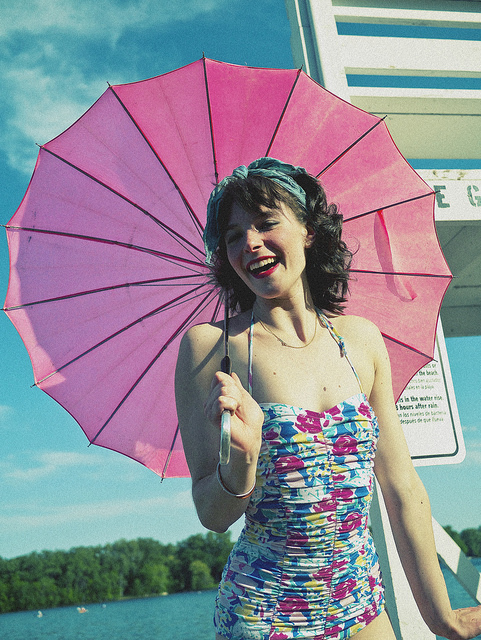

In [115]:
image

In [117]:
predict_from_sentence(image,"hi")

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\ml\lib\site-packages\ipykernel_launcher.py:16: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  app.launch_new_instance()
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\ml\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\ml\lib\site-packages\ipykernel_launcher.py:46: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
C:\Program Files (x86)\Microsoft Vis

Input: hi EOS
Predicted: EOS


In [134]:
def validate_from_user(image,question,ques_len,answer):
    image = image.unsqueeze(0)
    ques_len = torch.Tensor(ques_len.reshape(1)).int()
    question = torch.Tensor(question).view(1,-1)
    answer = torch.Tensor(answer).long()
    if torch.cuda.is_available():
        answer = answer.cuda()
    pred = predict(image,question,ques_len)
    question = question.squeeze(0)
    pred = pred.squeeze(0)
    accuracy = pred.eq(answer.view_as(pred)).sum().item()/len(answer)
    print("Accuracy:",accuracy)
    # Print Input
    decoded_words = []
    for index in question:
        decoded_words.append(train_dataset.voc.idex2word[index.item()])
        if index.item() == train_dataset.voc.EOS_token:
            break
    print("Input:"," ".join(decoded_words))
    # Print Answer
    decoded_words = []
    for index in answer:
        decoded_words.append(train_dataset.voc.idex2word[index.item()])
        if index.item() == train_dataset.voc.EOS_token:
            break
    print("Answer:"," ".join(decoded_words))
    # Print Predict
    decoded_words = []
    for index in pred:
        decoded_words.append(train_dataset.voc.idex2word[index.item()])
        if index.item() == train_dataset.voc.EOS_token:
            break
    print("Predicted:"," ".join(decoded_words))

In [135]:
validate_from_user(*train_dataset[878])

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\ml\lib\site-packages\ipykernel_launcher.py:16: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  app.launch_new_instance()
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\ml\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\ml\lib\site-packages\ipykernel_launcher.py:46: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
C:\Program Files (x86)\Microsoft Vis

Accuracy: 0.9565217391304348
Input: are the kids playing video games EOS
Input: yes EOS
Predicted: EOS
